# Notebook to perform batch effect correction and running SCENIC CLI

## Import libraries

In [1]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import time

import seaborn as sns
import scanpy
import scanpy.api as sc
from matplotlib import pyplot as plt
from sklearn import preprocessing
sc.settings.figdir = 'figures'

import matplotlib
import loompy as lp
import bbknn

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.settings.figdir = 'figures'
scanpy.api.set_figure_params(scanpy=True, dpi=80, dpi_save=1200, frameon=True, vector_friendly=False)

# Loading Pseudobulk datasets

In [3]:
#Read colormap
colormap = pd.read_csv('data/ColorMap.csv', sep=';')

In [4]:
#Import datasets
droplet_PB = scanpy.read_h5ad('/work/sduknn/Andreas/TM_MCA/TM/droplet_pseudobulk.h5ad')
facs_PB = scanpy.read_h5ad('/work/sduknn/Andreas/TM_MCA/TM/facs_pseudobulk.h5ad')
mca_PB = scanpy.read_h5ad('/work/sduknn/Andreas/TM_MCA/MCA/mca_pseudobulk.h5ad')

In [5]:
#remove unassigned cells
droplet_PB = droplet_PB[droplet_PB.obs['celltype'] != 'unassigned']
facs_PB = facs_PB[facs_PB.obs['celltype'] != 'unassigned']
mca_PB = mca_PB[mca_PB.obs['celltype'] != 'unassigned']

In [6]:
def tissue_from_name(scanpy):
    tissue = list()
    for idx, i  in enumerate(scanpy.obs.index):
        if i.startswith('Fetal_'):
            tissue.append((i.split('_')[0])+'_'+(i.split('_')[1]))
        elif i.startswith('Large_'):
            tissue.append((i.split('_')[0])+'_'+(i.split('_')[1]))
        else:
            tissue.append(i.split('_')[0])
        #also put in tissue
        #print(len(tissue))
    scanpy.obs['tissue'] = tissue
    scanpy.obs['tissue'] = pd.Categorical(scanpy.obs['tissue'])
    
tissue_from_name(droplet_PB)
tissue_from_name(facs_PB)
tissue_from_name(mca_PB)

In [7]:
#library size normalization
sc.pp.normalize_per_cell(droplet_PB, counts_per_cell_after=1e4)
sc.pp.normalize_per_cell(facs_PB, counts_per_cell_after=1e4)
sc.pp.normalize_per_cell(mca_PB, counts_per_cell_after=1e4)

#log transform
sc.pp.log1p(droplet_PB)
sc.pp.log1p(facs_PB)
sc.pp.log1p(mca_PB)

In [8]:
#Only use overlap between all datasets
overlap = set(droplet_PB.var_names.values) & set(facs_PB.var_names.values) & set(mca_PB.var_names.values)


droplet = droplet_PB[:, list(overlap)]
facs = facs_PB[:, list(overlap)]
mca = mca_PB[:, list(overlap)]

#Remove genes expressed in >10% of cells
sc.pp.filter_genes(droplet_PB, min_cells=(len(droplet.obs_names) / 10))
sc.pp.filter_genes(facs_PB, min_cells=(len(facs.obs_names) / 10))
sc.pp.filter_genes(mca_PB, min_cells=(len(mca.obs_names) / 10))

overlap = set(droplet_PB.var_names.values) & set(facs_PB.var_names.values) & set(mca_PB.var_names.values)

droplet_PB = droplet_PB[:, list(overlap)]
facs_PB = facs_PB[:, list(overlap)]
mca_PB = mca_PB[:, list(overlap)]





In [9]:
droplet_PB.raw = droplet_PB
facs_PB.raw = facs_PB
mca_PB.raw = mca_PB

In [10]:
#scale to unit variance
sc.pp.scale(droplet_PB, max_value=10)
sc.pp.scale(facs_PB, max_value=10)
sc.pp.scale(mca_PB, max_value=10)

In [11]:
#annotate protocol
droplet_PB.obs['protocol'] = '10X'
facs_PB.obs['protocol'] = 'Smartseq2'
mca_PB.obs['protocol'] = 'Microwell-seq'

In [12]:
#Make non-corrected dataset
merge = sc.AnnData.concatenate(droplet_PB, facs_PB, join = 'inner')

## Batch effect correction

### MNNcorrect

In [13]:
sc.tl.pca(merge)
sc.pp.neighbors(merge)

In [14]:
#t1 = time.time()


mnn, _, _ = sc.pp.mnn_correct(merge[merge.obs['protocol']=='10X'],
                              merge[merge.obs['protocol']=='Smartseq2'],
                              n_jobs = 20, svd_dim = 5, k = 10)


#t2 = time.time()
#print('Took '+str(time.timedelta(seconds=t2-t1)))

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


### BBKNN

In [15]:
bbknn = bbknn.bbknn(merge, neighbors_within_batch=10, n_pcs=10, copy=True, batch_key='protocol', trim=50)


In [16]:
bbknn

AnnData object with n_obs × n_vars = 1764 × 11003 
    obs: 'batch', 'celltype', 'n_counts', 'protocol', 'tissue'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'

In [17]:
mnn.X

array([[ 0.01300961, -0.0014819 , -0.00842928, ...,  0.01098447,
         0.02447207, -0.00363926],
       [ 0.00578486, -0.00063831, -0.00119404, ...,  0.01230099,
         0.01867773, -0.00875783],
       [ 0.0182852 , -0.00204941,  0.00211433, ...,  0.00836783,
         0.01864743,  0.00818765],
       ...,
       [ 0.00917568, -0.00361776,  0.01102399, ..., -0.00541953,
        -0.00320719,  0.0004862 ],
       [ 0.00046934, -0.00476625, -0.00578506, ..., -0.00492222,
        -0.00330314,  0.00246437],
       [-0.00035379, -0.00487119, -0.00109292, ..., -0.00684957,
        -0.00103219,  0.0018787 ]], dtype=float32)

In [18]:
bbknn.X

array([[ 1.6760213 , -0.19091281, -1.0859405 , ...,  1.4151233 ,
         3.152725  , -0.46884453],
       [ 0.77697533, -0.08573199, -0.1603732 , ...,  1.6521692 ,
         2.508641  , -1.1762807 ],
       [ 2.6093128 , -0.29245186,  0.30171695, ...,  1.194097  ,
         2.6610036 ,  1.1683841 ],
       ...,
       [ 1.0581719 , -0.4055675 ,  1.6721245 , ..., -0.868606  ,
        -0.46320274, -0.07541276],
       [-0.101311  , -0.54494005, -0.5610353 , ..., -0.78427196,
        -0.46320274,  0.18414332],
       [-0.20275685, -0.54517007,  0.05390432, ..., -1.0117601 ,
        -0.16297838,  0.10681945]], dtype=float32)

In [19]:
merge.X

array([[ 1.6760213 , -0.19091281, -1.0859405 , ...,  1.4151233 ,
         3.152725  , -0.46884453],
       [ 0.77697533, -0.08573199, -0.1603732 , ...,  1.6521692 ,
         2.508641  , -1.1762807 ],
       [ 2.6093128 , -0.29245186,  0.30171695, ...,  1.194097  ,
         2.6610036 ,  1.1683841 ],
       ...,
       [ 1.0581719 , -0.4055675 ,  1.6721245 , ..., -0.868606  ,
        -0.46320274, -0.07541276],
       [-0.101311  , -0.54494005, -0.5610353 , ..., -0.78427196,
        -0.46320274,  0.18414332],
       [-0.20275685, -0.54517007,  0.05390432, ..., -1.0117601 ,
        -0.16297838,  0.10681945]], dtype=float32)

## Plot UMAP's

In [20]:
di = {cell:color for cell,color in zip(colormap['celltype'], colormap['color_grad'])}


mnn.uns['celltype_colors'] = [di[x] for x in mnn.obs['celltype'].astype('category').cat.categories]
bbknn.uns['celltype_colors'] = [di[x] for x in bbknn.obs['celltype'].astype('category').cat.categories]
merge.uns['celltype_colors'] = [di[x] for x in merge.obs['celltype'].astype('category').cat.categories]

In [21]:
sc.tl.pca(mnn, svd_solver='arpack', n_comps=5)
sc.tl.pca(bbknn, svd_solver='arpack', n_comps=5)
sc.tl.pca(merge, svd_solver='arpack', n_comps=5)

sc.pp.neighbors(mnn, n_neighbors=10, n_pcs = 5)
sc.pp.neighbors(merge, n_neighbors=10, n_pcs = 5)

sc.tl.umap(mnn)
sc.tl.umap(bbknn)
sc.tl.umap(merge)

sc.tl.tsne(mnn)
sc.tl.tsne(bbknn)
sc.tl.tsne(merge)


In [22]:
#Not raster
sc.pl.umap(mnn, color=['celltype'],title = 'MNN' , save='mnn_umap_celltype_vecor.pdf')
#sc.pl.umap(bbknn, color=['celltype'], title = 'BBKNN', save='bbknn_umap_celltype.pdf')
#sc.pl.umap(merge, color=['celltype'], title = 'No correction', save='uncorrected_umap_celltype.pdf')

#sc.pl.umap(mnn, color=['protocol'],title = 'MNN' , save='mnn_umap_protocol.pdf')
#sc.pl.umap(bbknn, color=['protocol'], title = 'BBKNN', save='bbknn_umap_protocol.pdf')
#sc.pl.umap(merge, color=['protocol'], title = 'No correction', save='uncorrected_umap_protocol.pdf')


SyntaxError: positional argument follows keyword argument (<ipython-input-22-a5f6fd67bd95>, line 2)

... storing 'celltype' as categorical
... storing 'protocol' as categorical
... storing 'tissue' as categorical


saving figure to file figures/umapmnn_umap_celltype.pdf


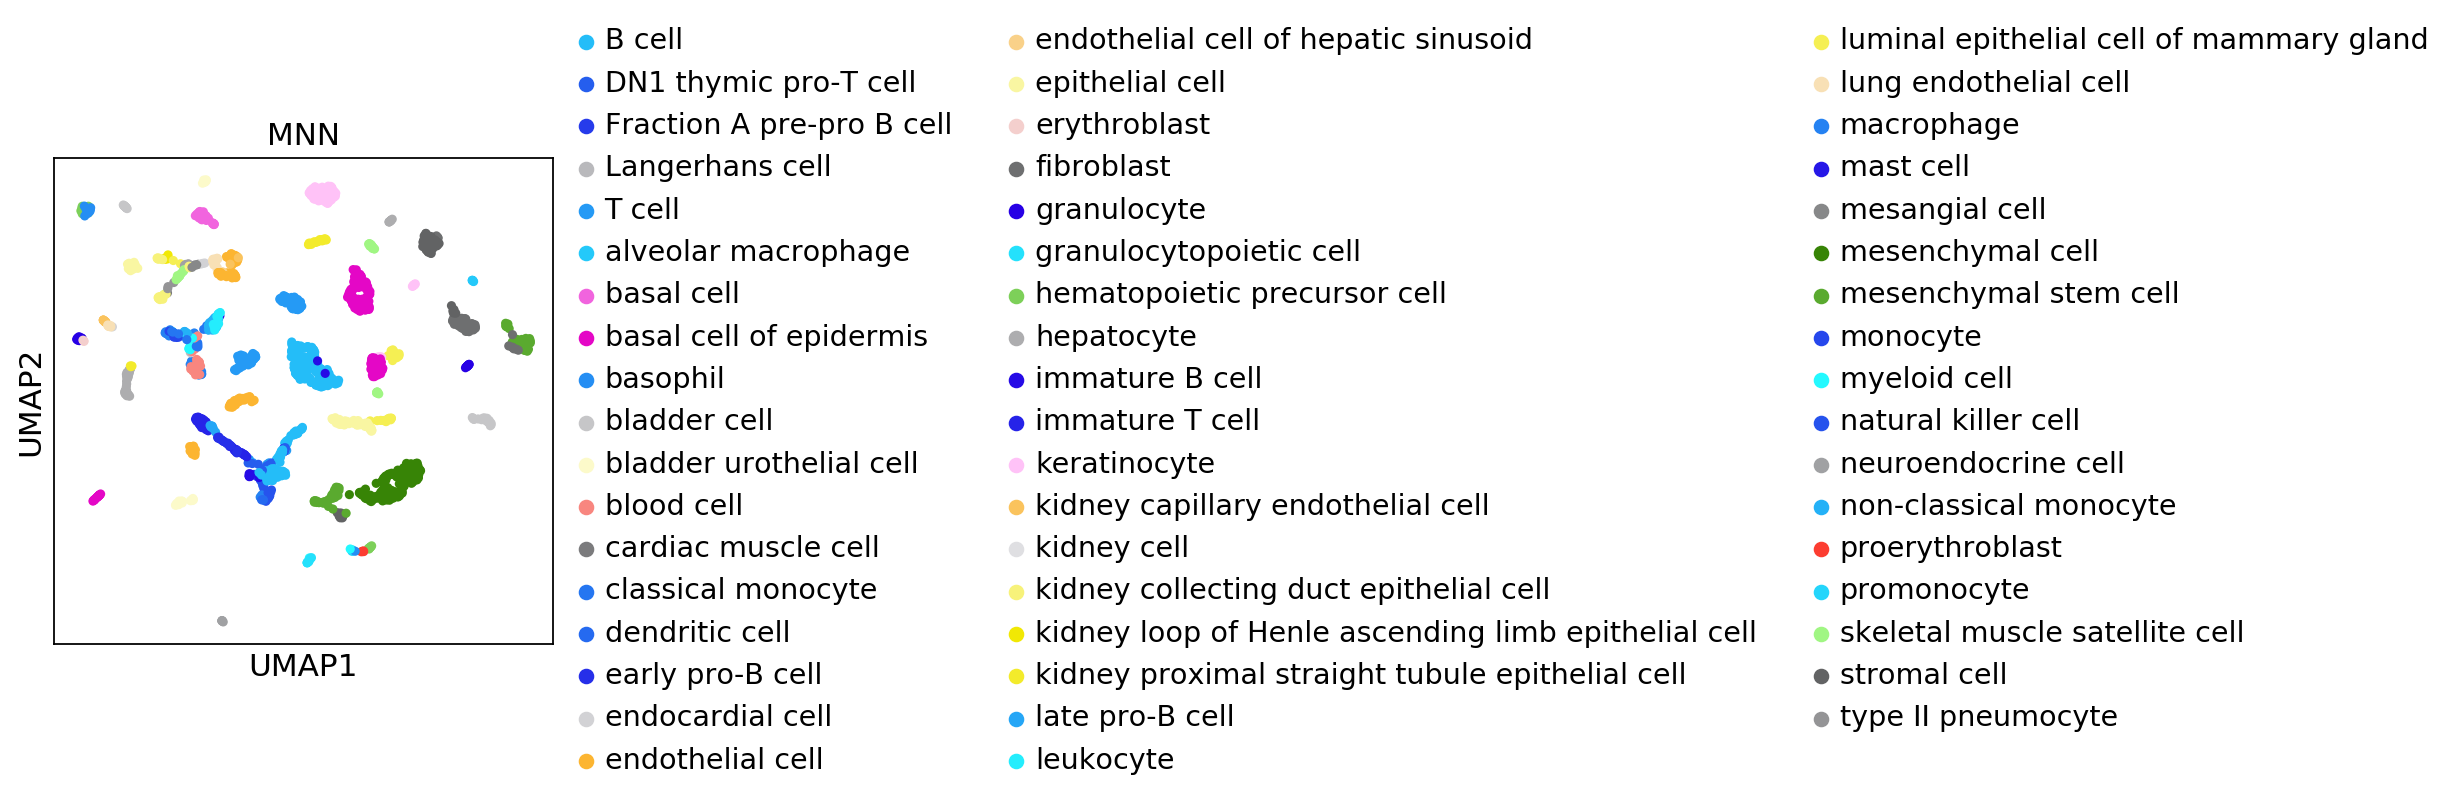

... storing 'celltype' as categorical
... storing 'protocol' as categorical
... storing 'tissue' as categorical


saving figure to file figures/umapbbknn_umap_celltype.pdf


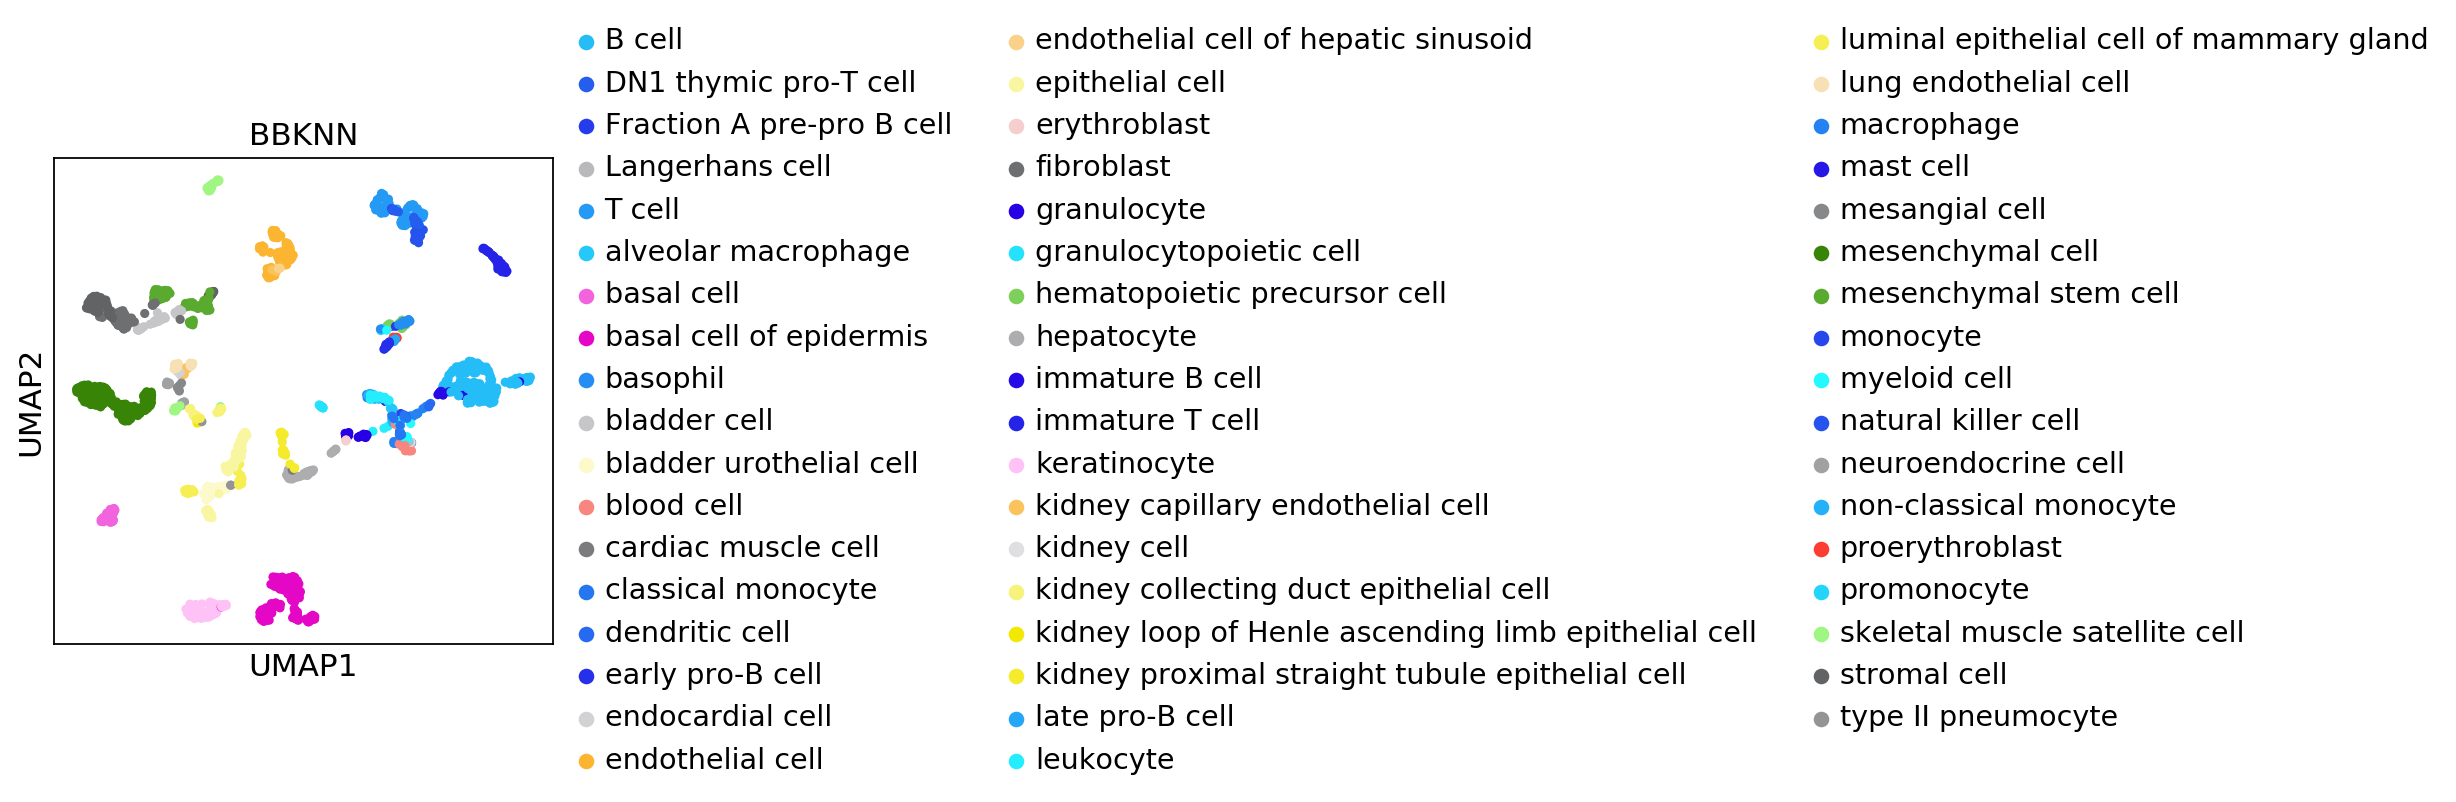

... storing 'celltype' as categorical
... storing 'protocol' as categorical
... storing 'tissue' as categorical


saving figure to file figures/umapuncorrected_umap_celltype.pdf


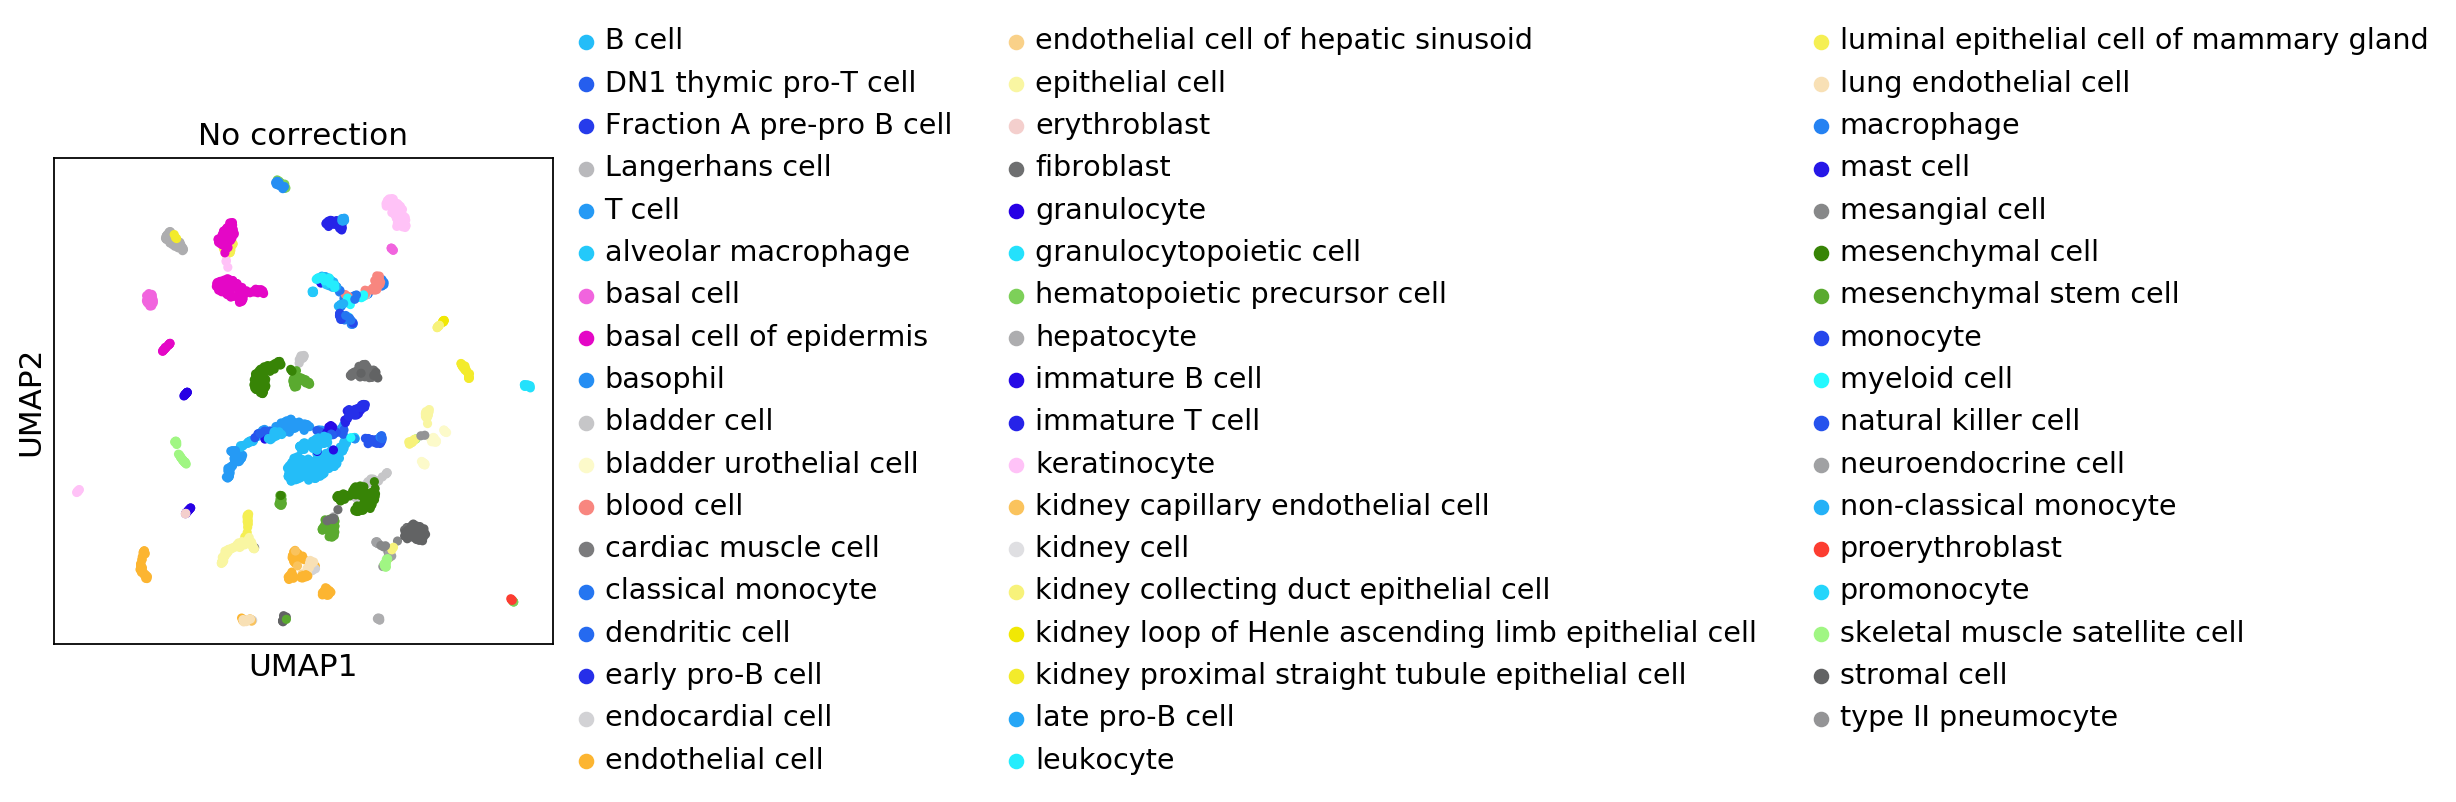

saving figure to file figures/umapmnn_umap_protocol.pdf


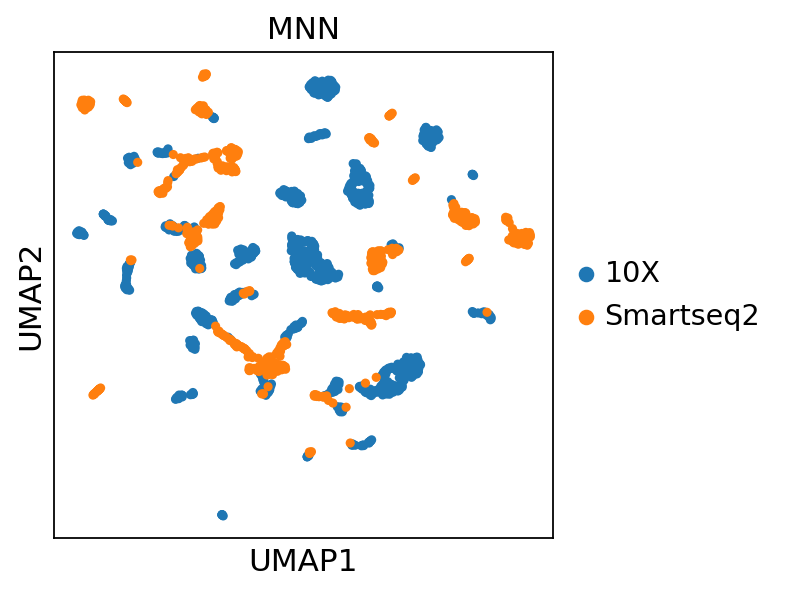

saving figure to file figures/umapbbknn_umap_protocol.pdf


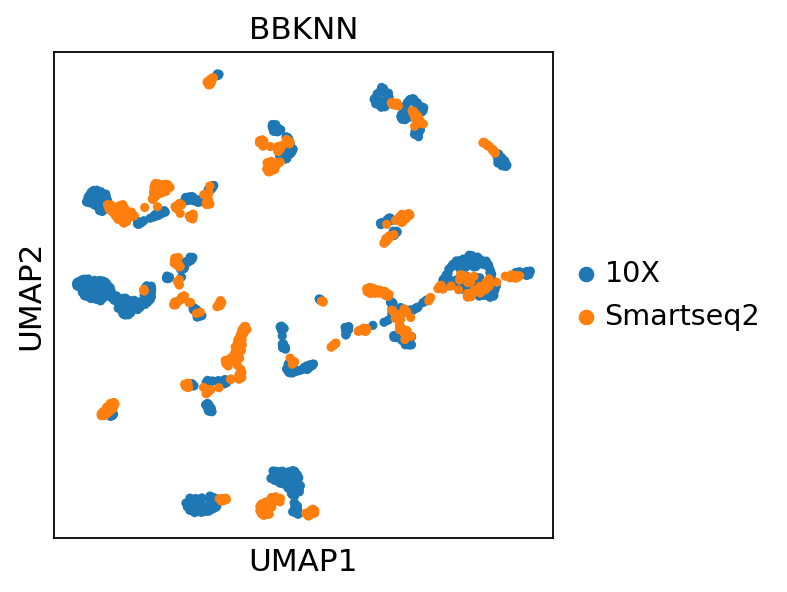

saving figure to file figures/umapuncorrected_umap_protocol.pdf


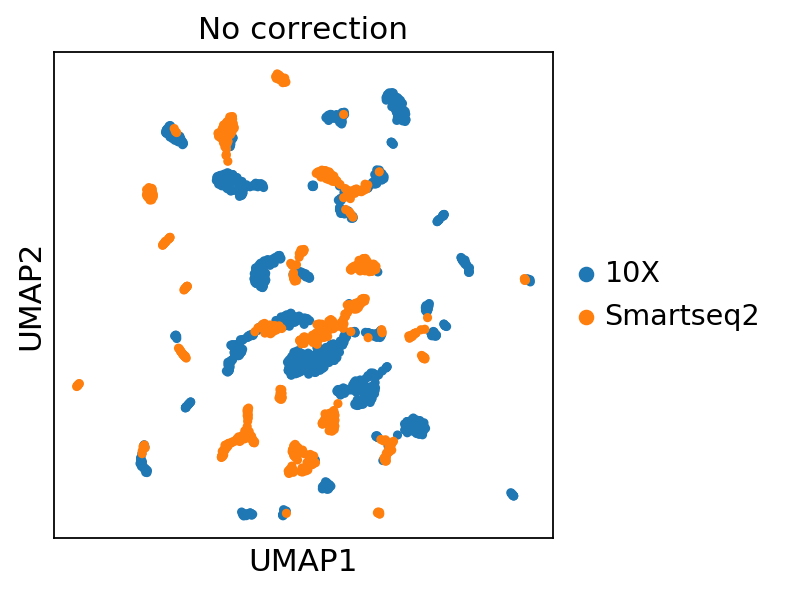

In [27]:
sc.pl.umap(mnn, color=['celltype'],title = 'MNN' , save='mnn_umap_celltype.pdf')
sc.pl.umap(bbknn, color=['celltype'], title = 'BBKNN', save='bbknn_umap_celltype.pdf')
sc.pl.umap(merge, color=['celltype'], title = 'No correction', save='uncorrected_umap_celltype.pdf')

sc.pl.umap(mnn, color=['protocol'],title = 'MNN' , save='mnn_umap_protocol.pdf')
sc.pl.umap(bbknn, color=['protocol'], title = 'BBKNN', save='bbknn_umap_protocol.pdf')
sc.pl.umap(merge, color=['protocol'], title = 'No correction', save='uncorrected_umap_protocol.pdf')


saving figure to file figures/tsnemnn_tsne_celltype.pdf


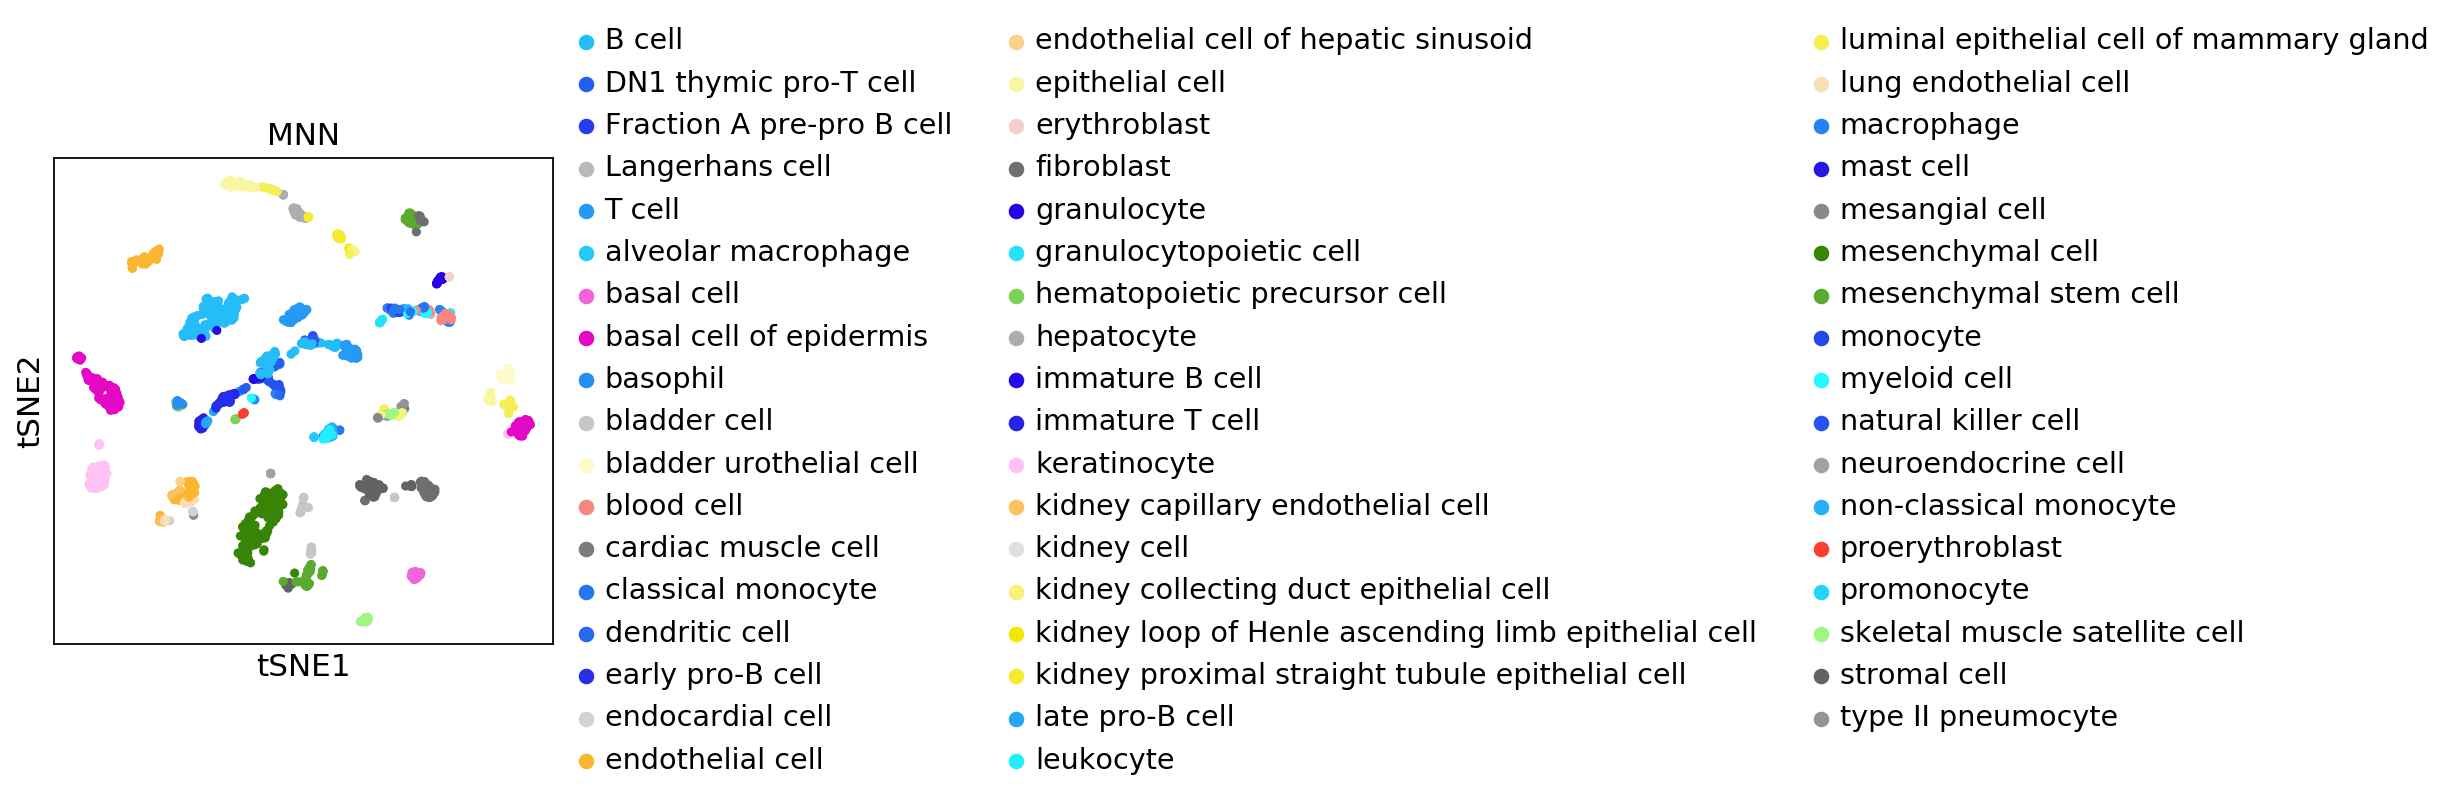

saving figure to file figures/tsnebbknn_tsne_celltype.pdf


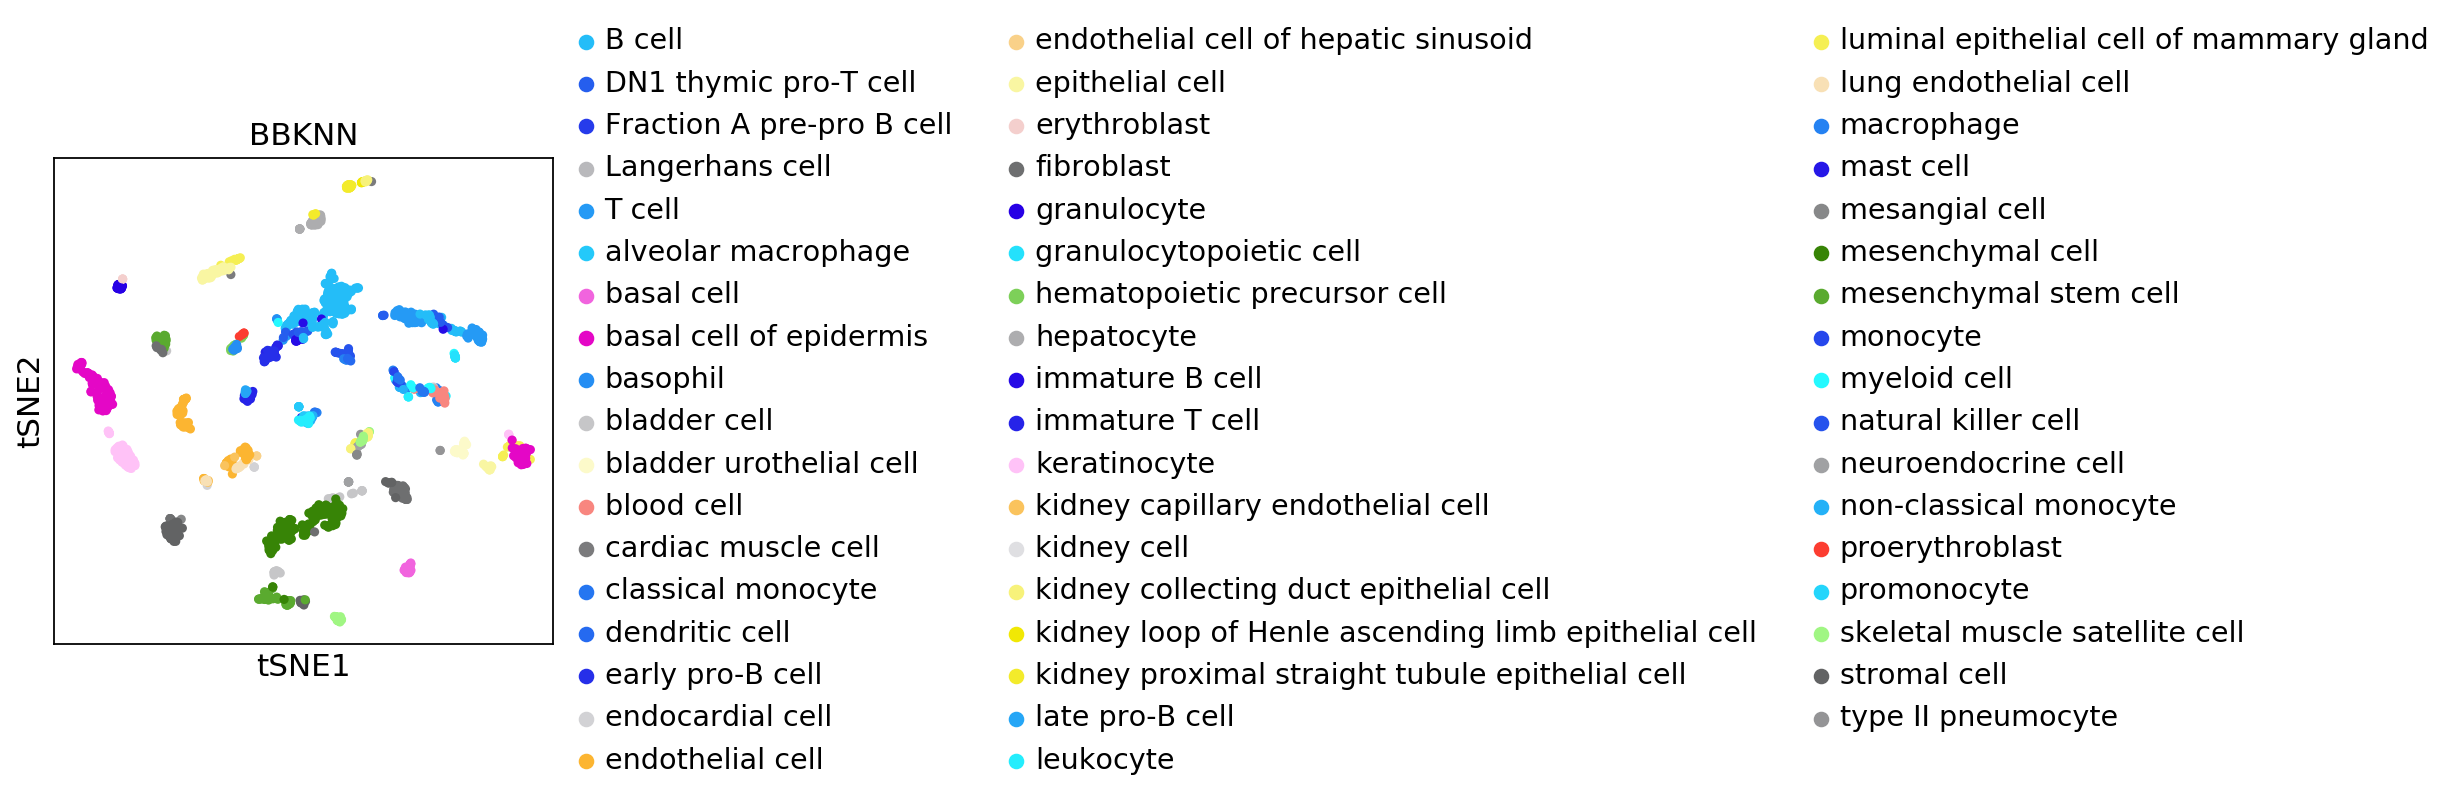

saving figure to file figures/tsneuncorrected_tsne_celltype.pdf


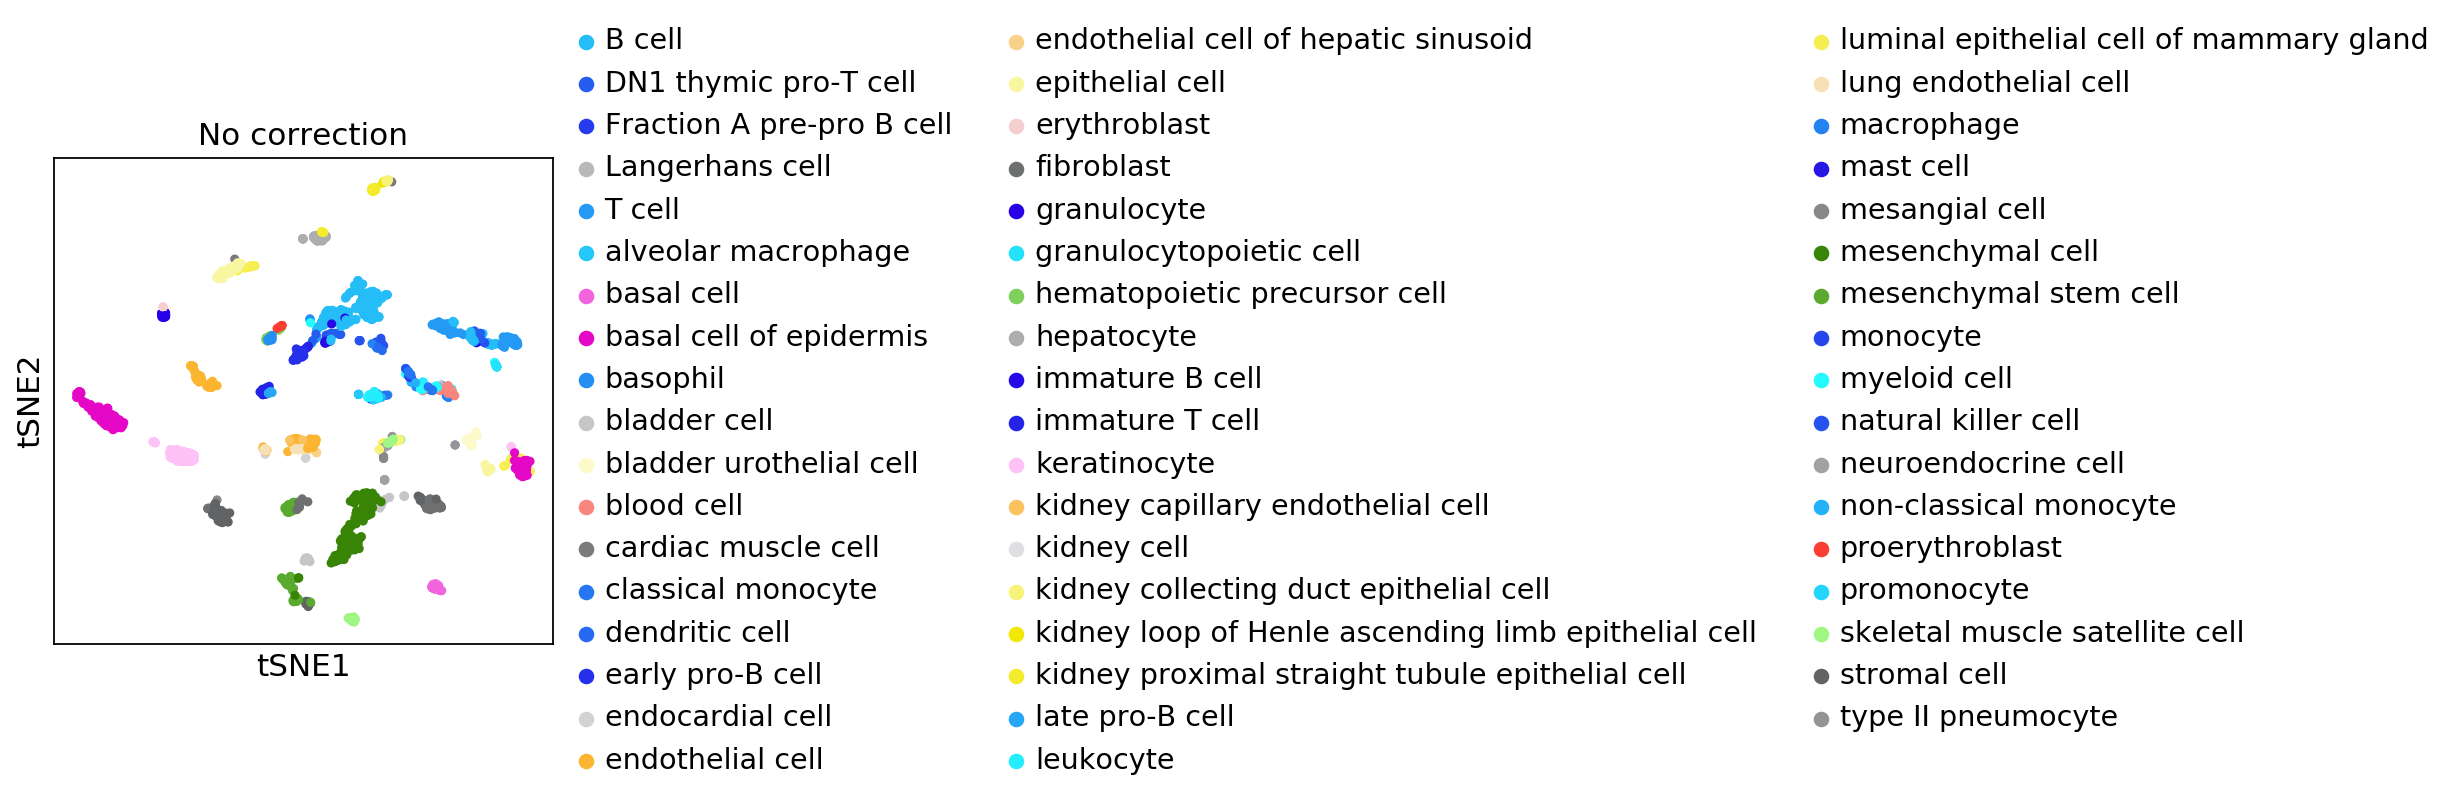

saving figure to file figures/tsnemnn_tsne_protocol.pdf


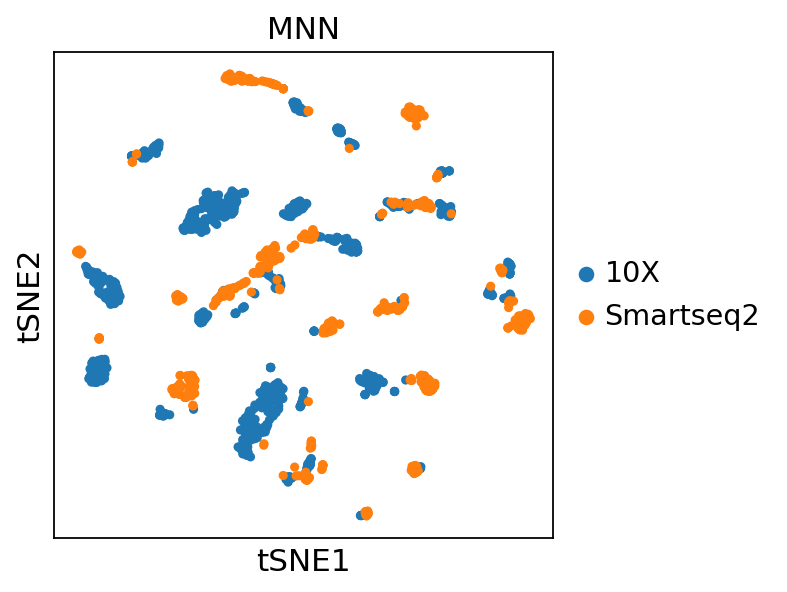

saving figure to file figures/tsnebbknn_tsne_protocol.pdf


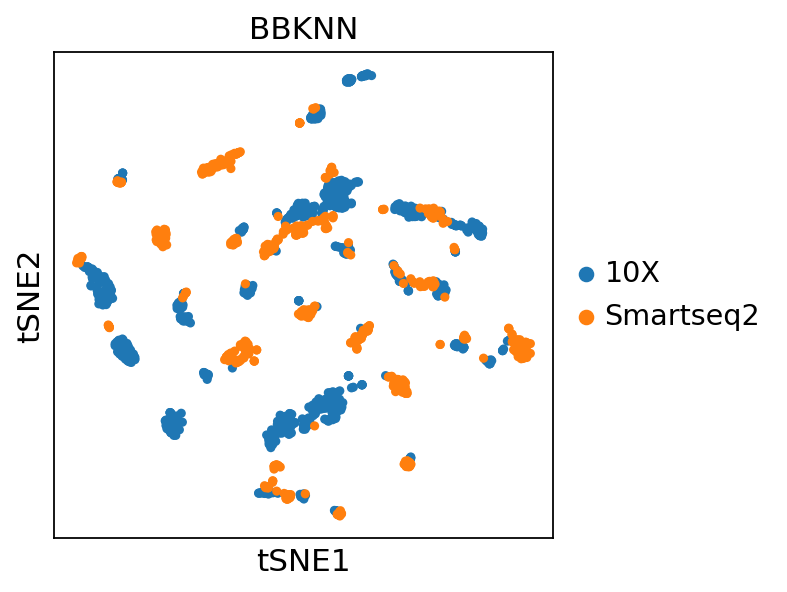

saving figure to file figures/tsneuncorrected_tsne_protocol.pdf


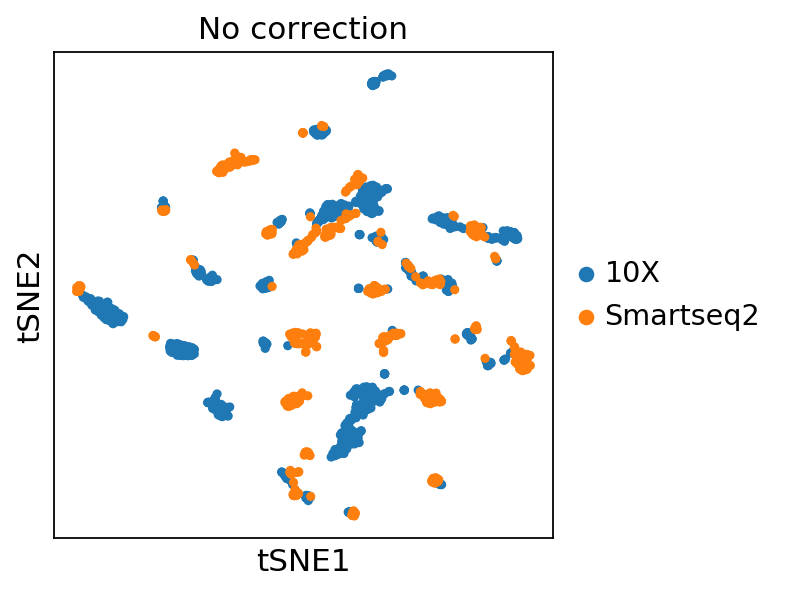

In [28]:
sc.pl.tsne(mnn, color=['celltype'],title = 'MNN' , save='mnn_tsne_celltype.pdf')
sc.pl.tsne(bbknn, color=['celltype'], title = 'BBKNN', save='bbknn_tsne_celltype.pdf')
sc.pl.tsne(merge, color=['celltype'], title = 'No correction', save='uncorrected_tsne_celltype.pdf')

sc.pl.tsne(mnn, color=['protocol'],title = 'MNN' , save='mnn_tsne_protocol.pdf')
sc.pl.tsne(bbknn, color=['protocol'], title = 'BBKNN', save='bbknn_tsne_protocol.pdf')
sc.pl.tsne(merge, color=['protocol'], title = 'No correction', save='uncorrected_tsne_protocol.pdf')


### Has expresseion space been corrected?

In [21]:
(merge.X != bbknn.X).sum()
#No gene expression values have been changed by bbknn

0

In [22]:
(merge.X != mnn.X).sum()
#Lots of gene expression values have been changed by mnn-correct

37154720

# Subsetting

In [37]:
mnn_spleen = mnn[mnn.obs.tissue == 'Spleen']
bbknn_spleen = bbknn[bbknn.obs.tissue == 'Spleen']
merge_spleen = merge[merge.obs.tissue == 'Spleen']

## Run SCENIC CLI

#### SCENIC on MNN corrected data

In [22]:
#Settings
wdir = "Batch_corrected"
os.chdir( wdir )


f_loom_path_scenic = "mnn.loom"
f_anndata_path = "mnn.h5ad"
f_pyscenic_output = "pyscenic_output_mnn.loom"
f_final_loom = 'mnn_scenic_integrated-output.loom'

DATA_FOLDER="/work/sduknn/Andreas/TM_MCA/SCENIC/Updated_analysis/database_SCENIC/tmp/bbknn"
RESOURCES_FOLDER="/work/sduknn/Andreas/TM_MCA/database_SCENIC/resources"
DATABASE_FOLDER = "/work/sduknn/Andreas/TM_MCA/database_SCENIC/databases/"

DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "mm9-*.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, '/work/sduknn/Andreas/TM_MCA/database_SCENIC/making_TF_file/mm_tfs.txt')


#### Prep expression files

In [31]:
mnn_spleen.write( f_anndata_path )

... storing 'celltype' as categorical
... storing 'protocol' as categorical
... storing 'tissue' as categorical


In [32]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(mnn_spleen.var_names) ,
}
col_attrs = {
    "CellID": np.array(mnn_spleen.obs_names) ,
    "nGene": np.array( np.sum(mnn_spleen.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(mnn_spleen.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, mnn_spleen.X.transpose(), row_attrs, col_attrs)

#### GRNBoost

In [38]:
!pyscenic grn {f_loom_path_scenic} {MM_TFS_FNAME} -o mnn_adj.tsv --num_workers 20

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synon

In [39]:
adjacencies = pd.read_csv("mnn_adj.tsv", index_col=False, sep='\t')

In [40]:
adjacencies.head()

,TF,target,importance
0,Irf5,Cd74,77.865054
1,Hmgb2,Birc5,76.902665
2,Pou2af1,Ly6d,74.386955
3,Hmgb2,Ccnb2,74.199056
4,Hmgb2,Cdca3,71.575860


#### RCisTarget

In [23]:
# ranking databases
f_db_names = ' '.join( glob.glob(DATABASES_GLOB) ).split(' ')[4]

# motif databases
MOTIF_ANNOTATIONS_FNAME

'/work/sduknn/Andreas/TM_MCA/database_SCENIC/resources/motifs-v9-nr.mgi-m0.001-o0.0.tbl'

In [24]:
f_db_names

'/work/sduknn/Andreas/TM_MCA/database_SCENIC/databases/mm9-tss-centered-10kb-7species.mc8nr.feather'

In [42]:
!pyscenic ctx mnn_adj.tsv \
    {f_db_names} \
    --annotations_fname {MOTIF_ANNOTATIONS_FNAME} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output mnn_reg.csv \
    --num_workers 20


/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synon

#### AUCell

In [44]:
! pyscenic aucell \
    {f_loom_path_scenic} \
    mnn_reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synon

### SCENIC on BBKNN corrected data

In [53]:
#Settings
wdir = "Batch_corrected"

f_loom_path_scenic = "bbknn.loom"
f_anndata_path = "bbknn.h5ad"
f_pyscenic_output = "pyscenic_output_bbknn.loom"

f_final_loom = 'bbknn_scenic_integrated-output.loom'

DATA_FOLDER="/work/sduknn/Andreas/TM_MCA/SCENIC/Updated_analysis/database_SCENIC/tmp/bbknn"
RESOURCES_FOLDER="/work/sduknn/Andreas/TM_MCA/database_SCENIC/resources"
DATABASE_FOLDER = "/work/sduknn/Andreas/TM_MCA/database_SCENIC/databases/"

DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "mm9-*.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, '/work/sduknn/Andreas/TM_MCA/database_SCENIC/making_TF_file/mm_tfs.txt')

#### Prep expression files

In [54]:
bbknn_spleen.write( f_anndata_path )

... storing 'celltype' as categorical
... storing 'protocol' as categorical
... storing 'tissue' as categorical


In [57]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(bbknn_spleen.var_names) ,
}
col_attrs = {
    "CellID": np.array(bbknn_spleen.obs_names) ,
    "nGene": np.array( np.sum(bbknn_spleen.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(bbknn_spleen.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, bbknn_spleen.X.transpose(), row_attrs, col_attrs)

#### GRNBoost

In [58]:
!pyscenic grn {f_loom_path_scenic} {MM_TFS_FNAME} -o bbknn_adj.tsv --num_workers 20

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synon

In [61]:
adjacencies = pd.read_csv("bbknn_adj.tsv", index_col=False, sep='\t')

In [62]:
adjacencies.head()

,TF,target,importance
0,Foxq1,Krt7,91.532884
1,Irf5,H2-Ab1,81.486024
2,Pou2f2,Cd79a,79.830131
3,Rpl7,Rps3,75.293785
4,Foxq1,Wfdc2,74.839383


#### RCisTarget

In [25]:
# ranking databases
f_db_names = ' '.join( glob.glob(DATABASES_GLOB) ).split(' ')[4]

# motif databases
MOTIF_ANNOTATIONS_FNAME

'/work/sduknn/Andreas/TM_MCA/database_SCENIC/resources/motifs-v9-nr.mgi-m0.001-o0.0.tbl'

In [64]:
!pyscenic ctx bbknn_adj.tsv \
    {f_db_names} \
    --annotations_fname {MOTIF_ANNOTATIONS_FNAME} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output bbknn_reg.csv \
    --num_workers 12


/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synon

#### AUCell

In [65]:
! pyscenic aucell \
    {f_loom_path_scenic} \
    bbknn_reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synon

### SCENIC on un-corrected data

In [67]:
#Settings
wdir = "Batch_corrected"

f_loom_path_scenic = "merge.loom"
f_anndata_path = "merge.h5ad"
f_pyscenic_output = "pyscenic_output_merge.loom"

f_final_loom = 'merge_scenic_integrated-output.loom'

DATA_FOLDER="/work/sduknn/Andreas/TM_MCA/SCENIC/Updated_analysis/database_SCENIC/tmp/bbknn"
RESOURCES_FOLDER="/work/sduknn/Andreas/TM_MCA/database_SCENIC/resources"
DATABASE_FOLDER = "/work/sduknn/Andreas/TM_MCA/database_SCENIC/databases/"

DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "mm9-*.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, '/work/sduknn/Andreas/TM_MCA/database_SCENIC/making_TF_file/mm_tfs.txt')

#### Prep expression files

In [68]:
merge_spleen.write( f_anndata_path )

... storing 'celltype' as categorical
... storing 'protocol' as categorical
... storing 'tissue' as categorical


In [69]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(merge_spleen.var_names) ,
}
col_attrs = {
    "CellID": np.array(merge_spleen.obs_names) ,
    "nGene": np.array( np.sum(merge_spleen.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(merge_spleen.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, merge_spleen.X.transpose(), row_attrs, col_attrs)

#### GRNBoost

In [70]:
!pyscenic grn {f_loom_path_scenic} {MM_TFS_FNAME} -o merge_adj.tsv --num_workers 12

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synon

In [71]:
adjacencies = pd.read_csv("merge_adj.tsv", index_col=False, sep='\t')

In [72]:
adjacencies.head()

,TF,target,importance
0,Hmgb2,Ccna2,90.798272
1,Foxq1,Krt7,89.567339
2,Tal1,Epor,83.203758
3,Hmgb2,Birc5,79.185549
4,Ets1,Dpep2,77.715799


#### RCisTarget

In [73]:
# ranking databases
f_db_names = ' '.join( glob.glob(DATABASES_GLOB) ).split(' ')[4]

# motif databases
MOTIF_ANNOTATIONS_FNAME

'/work/sduknn/Andreas/TM_MCA/database_SCENIC/resources/motifs-v9-nr.mgi-m0.001-o0.0.tbl'

In [74]:
!pyscenic ctx merge_adj.tsv \
    {f_db_names} \
    --annotations_fname {MOTIF_ANNOTATIONS_FNAME} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output merge_reg.csv \
    --num_workers 12


/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synon

#### AUCell

In [75]:
! pyscenic aucell \
    {f_loom_path_scenic} \
    merge_reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synon